# Blood Glucose Control - EDA

**Name:** Aniket Srinivasan Ashok



### Import Data

There are multiple data sets each corresponding to a person with diabetes. Please load the files into a single data set while retaining the ability to distinguish between the PWD. 

In [23]:
import pandas as pd
import os

# Initializing list to collect dataframes:
dataframes = []

# Passing through directory containing all datasets:
for file in os.listdir(os.path.join("..", "data")):
    # We set the sender_id to the ID found in the filename (assuming they will all be unique):
    sender_id = file.split(".")[0].split("_")[1]
    # Reading this dataframe:
    this_dataframe = pd.read_csv(os.path.join("..", "data", file))
    # Setting the sender_id column to the extracted sender_id:
    this_dataframe["sender_id"] = sender_id
    dataframes.append(this_dataframe)
    
# Loading the files into a single dataset:
dataframe = pd.concat(dataframes)
dataframe

,date,sender_id,bgl,bgl_date_millis,text,template,msg_type,affects_fob,affects_iob,dose_units,food_g,food_glycemic_index,dose_automatic,fp_bgl,message_basal_change,__typename,trend
0,2024-05-01 00:00:27.029000-05:00,500030,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT
1,2024-05-01 00:05:27.183000-05:00,500030,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT
2,2024-05-01 00:10:26.949000-05:00,500030,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT
3,2024-05-01 00:15:27.180000-05:00,500030,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT
4,2024-05-01 00:20:27.021000-05:00,500030,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32170,2024-07-31 23:44:59-04:00,679372,165.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT
32171,2024-07-31 23:48:03-04:00,679372,169.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT
32172,2024-07-31 23:52:06-04:00,679372,165.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT
32173,2024-07-31 23:55:08-04:00,679372,164.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT


### Two Data Visualizations

Create at least two visualizations that are of interest to you. They can be things that would be useful information for a PWD to know, or they could be useful for informing future modeling work. If you aren't sure what to visualize try recreating common diabetes data visualizations that you can find on the internet. 

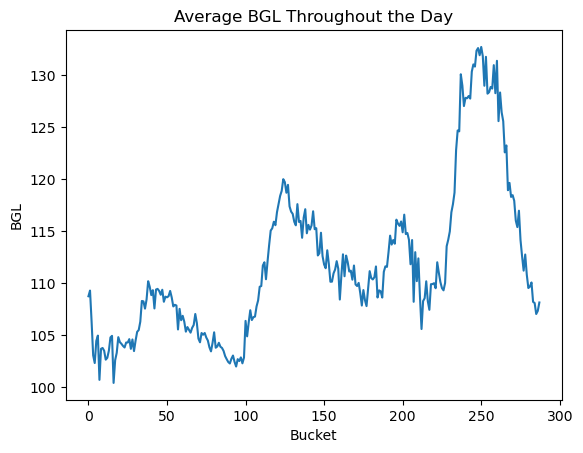

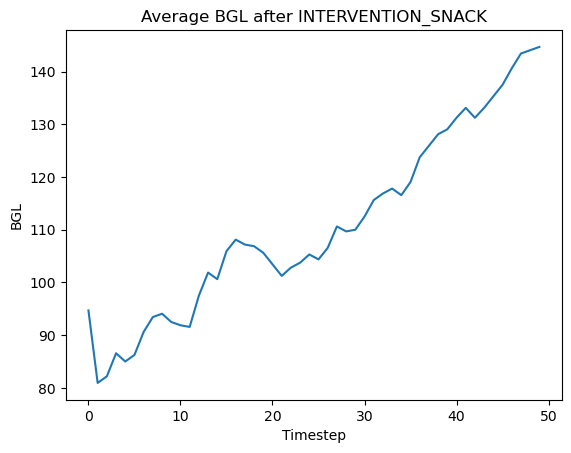

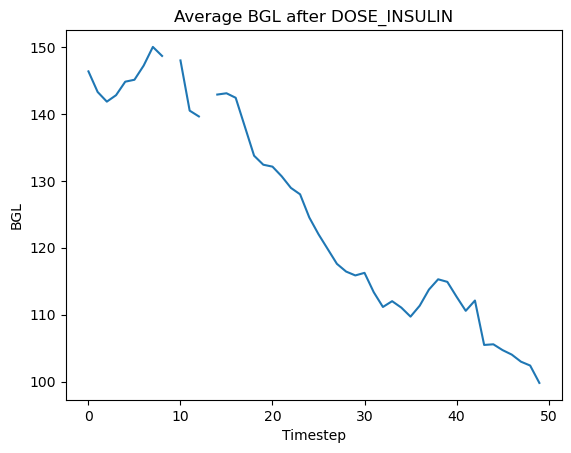

In [185]:
# My mother has T2D, and one of my close friends had T1D. I brainstormed things both of them have told me about
# their condition, and what they wish they knew:
#   * their average BGL throughout various times in the day (as a standard time-series)
#   * their BGL spikes after eating foods (how much it spikes, how quickly it spikes, how long it takes to level)
#   * what foods impact their BGL in what ways (e.g. impact of carbs v.s. impact of sugars, by glycemic index)
#   * how activity and sleep affects BGL (could be part of the standard time-series)
#   * hormonal impacts on BGL (e.g. influences of their menstruation cycle)

# The visualizations I'll make:
#   * displaying average 

from dateutil import parser
import datetime
import matplotlib.pyplot as plt


# CLEANING DATA (and some basic feature engineering)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# For converting datestrings into the standardised format "%Y-%m-%d %H:%M:%S".
def datetime_conversion(datestring: str):
    """
    Converts datestrings into the standardised format "%Y-%m-%d %H:%M:%S".
    """
    converted = str(datetime.datetime.fromisoformat(datestring))
    if len(str(converted)) >= 20:
        converted = converted[:19]
    return converted


def clean_timestamps(df: pd.DataFrame, datetime_name: str, ascending=True):
    """
    Returns a pd.DataFrame with the datetime_name column converted to the standardised format "%Y-%m-%d %H:%M:%S".
    """
    dataframe_new = df.copy()
    
    pd.options.mode.chained_assignment = None   # overriding false positive Pandas warning
    dataframe_new[datetime_name] = [datetime_conversion(datestring) for datestring in dataframe_new[datetime_name]]
    pd.options.mode.chained_assignment = "warn" # resetting to default value
    
    return dataframe_new


def convert_to_timestamps(df: pd.DataFrame, datetime_name: str, new_datetime_name: str, 
                          datetime_format="%Y-%m-%d %H:%M:%S"):
    """
    Converts timestamps in the datetime_name column (in a provided format) to pd.TimeStamp objects, stored in a
    new column new_datetime_name of df. 
    """
    df[new_datetime_name] = pd.to_datetime(df[datetime_name], format=datetime_format)
    df.set_index(new_datetime_name)
    return df


def get_second_of_day(timestamp: str):
    """
    Gets the second of the day given a timestamp in the "%Y-%m-%d %H:%M:%S" format.
    """
    hour, minute, second = timestamp.split(" ")[1].split(":")
    seconds = int(second) + 60*int(minute) + 60*60*int(hour)
    return seconds
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



# I'll be making these visualizations on only one of the datasets above, since I think this is more relevant for
# individual PWDs.
indiv_df = dataframe[dataframe["sender_id"] == "500030"]

# Cleaning up "date" column (we don't need millisecond precision):
#   note: this removes timezone information, which I wasn't quite sure how to deal with yet.
indiv_df = clean_timestamps(individual_dataframe, datetime_name="date")
indiv_df = convert_to_timestamps(individual_dataframe_series, "date", "date_ts")
# Creating "seconds" column that contains the seconds elapsed in the current day:
indiv_df["seconds"] = [get_second_of_day(timestamp) for timestamp in indiv_df["date"]]



# VISUAL 1: Average BGL Throughout the Day, using "Buckets"
#   since readings are not taken in exact intervals in the dataset, it makes most sense to segment them into
#   intervals or "buckets" which is what is done here.
#   the resolution of the averaging can be changed by modifying _BUCKET_SIZE (interval size in seconds).
#   this idea can be applied to plotting daily values, or average over any (sufficiently large) time interval. 
_BUCKET_SIZE = 300
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def create_buckets(df: pd.DataFrame, seconds_name: str, bucket_size: int): 
    """
    Creates a column that places every timestamp into a bucket, based on the time of day.
    """
    df["bucket"] = [(second // bucket_size) for second in df[seconds_name]]
    return df


def average_by_bucket(df: pd.DataFrame, target_column: str, max_bucket: int):
    """
    Given a DataFrame and the maximum value for "bucket", calculates the average of all target_column for that
    bucket and returns it as a dictionary.
    """
    averages = dict()
    for bucket in range(0, max_bucket):
        this_series = df[df["bucket"] == bucket]
        this_mean = this_series[target_column].mean()
        averages[bucket] = this_mean
    return averages


def plot_by_buckets(bucket_dict: dict):
    """
    Plots a bucket_dict created by the bucketing method(s) above.
    """
    averages = list(bucket_dict.values())
    plt.plot(averages)
    plt.title("Average BGL Throughout the Day")
    plt.xlabel("Bucket")
    plt.ylabel("BGL")
    plt.show()
    return True


# Plotting the averages:
indiv_df = create_buckets(indiv_df, "seconds", _BUCKET_SIZE)
averages = average_by_bucket(indiv_df, "bgl", 24*60*60//_BUCKET_SIZE)
assert(plot_by_buckets(averages))
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Extensions to this idea:
#   * adding a plot that shows the maximum/minimum value attained throughout all time for a specific bucket
#   * highlighting time asleep/awake separately (would vary by PWD)
#   * highlighting (average) meal times and insulin dosage (quantity and time)




# VISUAL 2+3: Average BGL After Specific Events
#   it's important (and interesting!) to know how, on average, certain actions/events (such as insulin usage, 
#   intervention snacks, etc.) impact blood glucose levels.
#   here, I've created graphs for the two events listed above. it's clear that intervention snacks increase 
#   BGL and insulin usage reduces BGL in the short term.
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def get_after_event(df: pd.DataFrame, target_name: str, event_name: str, n_timesteps: int):
    """
    Returns an array containing n values of target_name after insulin was used.
    """
    values = list()
    i = 0
    while (i < len(df)):
        # Look for the event in "msg_type":
        if df["msg_type"].iloc[i] == event_name:
            # Add the forward-look into the collected values (as far as possible):
            look_forward = min(len(df)-1, i+n_timesteps)
            values.append(df[target_name].iloc[i:look_forward])
        i += 1
    return values


def average_get_after_event(df: pd.DataFrame, target_name: str, event_name: str, n_timesteps: int):
    """
    Calculates the average over all events by timestep.
    """
    values = get_after_event(df, target_name, event_name, n_timesteps)
    averages = dict()
    for i in range(0, n_timesteps):
        this_sum = 0
        for j in range(0, len(values), n_timesteps):
            try: 
                this_sum += values[j].iloc[i]
            except Exception as e:
                print(i, j)
                this_sum += 0
        averages[i] = this_sum / (len(values) / n_timesteps)
    return averages


def plot_by_event(averages_dict: dict, title=""):
    """
    Plots averages as calculated by the method(s) above.
    """
    averages = list(averages_dict.values())
    plt.plot(averages)
    plt.title(f"Average BGL after {title}")
    plt.xlabel("Timestep")
    plt.ylabel("BGL")
    plt.show()
    return True


avg_intervention_snack = average_get_after_event(indiv_df, "bgl", "INTERVENTION_SNACK", 50)
assert(plot_by_event(avg_intervention_snack, "INTERVENTION_SNACK"))

avg_dose_insulin = average_get_after_event(indiv_df, "bgl", "DOSE_INSULIN", 50)
assert(plot_by_event(avg_dose_insulin, "DOSE_INSULIN"))
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Remarks:
#   * slightly buggy implementation, but it works for the visual here


### Ask a question(s) about the data and/or diabetes!
When creating the visualizations you probably had some questions about managing T1D. Ask some questions that might interest you and our diabetes experts will do their best to answer them for you! *Consider this an AMAA about diabetes.* 

1. How do you know beforehand when to take insulin? Especially on times where you are forced to go off schedule, such as traveling on flights? Is it mostly instinct, or can you somehow predict beforehand when and how your BGL will fluctuate?

2. This data is awesome! Would be incredibly helpful for PWD to have access to such data for their own lives. Are there any other data you collect in a time-series fashion, or does most of the real-world data follow the structure given here?

### Final Task

Thanks for showing interest in our project! We plan to incorporate the best/most interesting visualizations into a substack post in the future. 

Please remember to create a pull request with your updated template, don't forget to rename the file to something that we can identify you with, e.g: `eda_[your_name].ipynb`